# Домашнее задание 1. Сбор данных

При решении реальных задач мы почти никогда не имеем дело с "хорошими" исходными данными, уже подготовленными для обработки и анализа. Как правило на входе имеются неструкткрированные данные в "грязном" виде, например необработанные тексты, изображения или аудио файлы. Иногда нет даже этого, и данные приходится собирать из разных доступных источников: разнообразных баз данных, внешних сервисов и даже электронных таблиц. После того, как данные получены, их унифицируют, очищают от шума, преобразовывают в нужный вид и сохраняют для дальнейшего анализа. В одном из традиционных подходов к [Data Mining](http://www.wikiwand.com/en/Online_analytical_processing) этот процесс называется Extract-Transform-Load ([ETL](http://www.wikiwand.com/en/Extract,_transform,_load)).

Цель этого задания собрать первые данные о пользователях из обучающей выборки и провести простейший качественный анализ. В ходе решения будут использованы:
1. [numpy](http://www.numpy.org/) -- библиотека для работы с многомерными массивами
2. [pandas](http://pandas.pydata.org/) -- библиотека, позволяющая удобно работать с различными типами данных
3. [requests](http://docs.python-requests.org/en/latest/) -- библиотека, которую можно использовать для вызова HTTP запросов
4. [python-twitter](https://github.com/bear/python-twitter/tree/master/twitter) -- обертка для Twitter API
5. [matplotlib](http://matplotlib.org/) -- библиотека для рисования графиков в python

Первым делом импортируем необходимые библиотеки и убеждаемся, что все установлено.

In [22]:
import pandas as pd
import numpy as np
import pylab as pl
import mpl_toolkits.basemap as bm
import twitter
import requests
import datetime
import dateutil
import csv
import os
import json
import seaborn
import time
# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Чтение исходных данных из файла

Считываем исходные данные из файла в data frame библиотеки pandas. Полученный data frame должен иметь целочисленный ключ и две колонки:
1. uid -- идентификатор пользователя
2. cat -- числовой номер класса

In [2]:
TRAINING_SET_PATH = "/Users/KristinaFedorenko/Downloads/train.csv"
TESTING_SET_PATH = "/Users/KristinaFedorenko/Downloads/test.csv"
df_users_train = pd.read_csv(TRAINING_SET_PATH, sep=",", header=0)
df_users_ex = pd.read_csv(TESTING_SET_PATH, sep=",", header=0)
df_users_ex['cls'] = None
df_users = pd.concat([df_users_train, df_users_ex])
df_users.head()

,uid,cls
0,202388889,1.0
1,1392518336,0.0
2,361208576,1.0
3,1535215357,1.0
4,4396196375,1.0


Построим распределение целевой переменной. Требуется получить [barchart](http://www.wikiwand.com/en/Bar_chart), в котором высота столбика, соответствующего каждому из классов, пропорциональна количеству пользователей этого класса. По горизонтальной оси отложены классы (positive, negative), а по вертикальной -- количество пользователей.

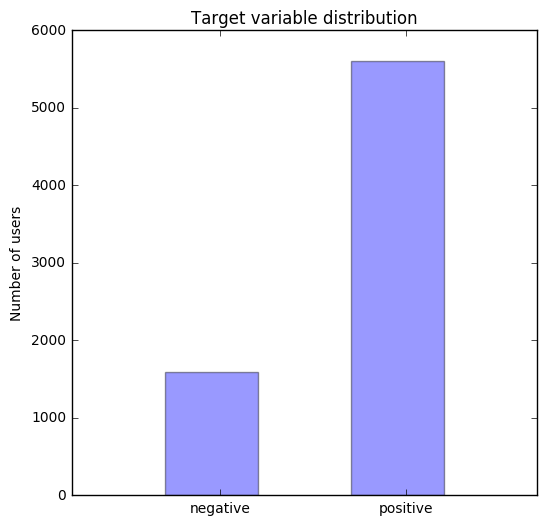

In [3]:
# Compute the distribution of the target variable
counts, bins = np.histogram(df_users_train["cls"], bins=[0,1,2])

# Plot the distribution
pl.figure(figsize=(6,6))
pl.bar(bins[:-1], counts, width=0.5, alpha=0.4)
pl.xticks(bins[:-1] + 0.3, ["negative", "positive"])
pl.xlim(bins[0] - 0.5, bins[-1])
pl.ylabel("Number of users")
pl.title("Target variable distribution")
pl.show()

## Сбор данных

Для того чтобы разработать модель, которая предсказывает значение целевой переменной для произвольного пользователя, недостаточно знать только значения идентификаторов пользоватей. Причина в том, что _user_id_ для пользователя никак не зависит от целевой переменной -- идентификатор генерируется на основании времени регистрации, сервера, обрабатывающего запрос, и номера пользователя ([подробности](https://dev.twitter.com/overview/api/twitter-ids-json-and-snowflake)).

Поэтому нам потребуется загрузить дополнительную информацию о каждом пользователе, иначе говоря провести сбор данных (data collection). Наиболее важную информацию можно загрузить из [Twitter](https://dev.twitter.com/rest/public) [API](http://www.wikiwand.com/en/Representational_state_transfer). При желании можно воспользоваться и другими источниками -- об этом ниже.

Для того, чтобы получить доступ к API прежде всего необходимо зарегистрироваться в Twitter в качестве разработчика и создать свое [приложение](https://apps.twitter.com/). После создания приложения будет доступен набор ключей, которые мы будем использовать для аутентификации. Эти ключи необходимо скопировать в соответствующие константы ниже. Подробнее о том, как работает аутентификация в Twitter API можно почитать [по ссылке](https://dev.twitter.com/oauth/application-only), хотя это нужно скорее для ознакомления: библиотека обращения с API позаботится о механизме аутентификации за нас.

In [4]:
CONSUMER_KEY = "NIdJmEzKanvYMoZMQOLRIWGhu"
CONSUMER_SECRET = "OJVCVs1sG5RxOR1XRn30rj2x5BoPZvPzmSmA8kfLMBr2JjH5yZ"

ACCESS_TOKEN_KEY = "105892440-hiutXI6zWd1XjrQJaotg7GbW6Mt1gihXCnE4njZH"
ACCESS_TOKEN_SECRET = "RxIHlIylRycp8dPZfV8fXSM2WtMP74lteIp5P6jxwh4XW"

api = twitter.Api(consumer_key=CONSUMER_KEY, 
                  consumer_secret=CONSUMER_SECRET, 
                  access_token_key=ACCESS_TOKEN_KEY, 
                  access_token_secret=ACCESS_TOKEN_SECRET)

Twitter API предоставляет информацию о местонахождении пользователя, но эта информация представлена в текстовом виде, например так:
```
"location": "San Francisco, CA"
```
Такие текстовый описания не слишком удобны для анализа, поэтому наша цель -- получить более структурированную информацию, такую как географические координаты, страна, город и т.д. Для этого удобно использовать геоинформационный сервис, например [GeoNames](http://www.geonames.org/export/web-services.html). Для его использования также необходимо зарегистрироваться, подтвердить регистрацию и включить поддержку API. После этого можно будет посылать запросы для нахождения нужной информации. Например на запрос
```
http://api.geonames.org/search?q="San Francisco, CA"&maxRows=10&username=demo
```
возвращается результат,
```javascript
{
    "totalResultsCount": 2112,
    "geonames": [
        {
            "countryId": "6252001",
            "adminCode1": "CA",
            "countryName": "United States",
            "fclName": "city, village,...",
            "countryCode": "US",
            "lng": "-122.41942",
            "fcodeName": "seat of a second-order administrative division",
            "toponymName": "San Francisco",
            "fcl": "P",
            "name": "San Francisco",
            "fcode": "PPLA2",
            "geonameId": 5391959,
            "lat": "37.77493",
            "adminName1": "California",
            "population": 805235
        },
        {
            "countryId": "6252001",
            "adminCode1": "CA",
            "countryName": "United States",
            "fclName": "spot, building, farm",
            "countryCode": "US",
            "lng": "-122.3758",
            "fcodeName": "airport",
            "toponymName": "San Francisco International Airport",
            "fcl": "S",
            "name": "San Francisco International Airport",
            "fcode": "AIRP",
            "geonameId": 5391989,
            "lat": "37.61882",
            "adminName1": "California",
            "population": 0
        }
    ]
}
```
из которого легко извлечь нужную информацию.

**Замечание: для запросов необходимо использовать своего пользователя, кроме того количество запросов ограничего 30к в день**.

Первым делом нам понадобится функция, которая возвращает информацию о местоположении для данного текстового запроса.

In [5]:
GEO_USER_NAME = "g_o0_stav"

def get_coordinates_by_location(location):    
    response = requests.get("http://api.geonames.org/searchJSON", params={"q": location, "username": GEO_USER_NAME, "maxRows": 1})
    if response.status_code == 200:
        json = response.json()
        if json.get(u"totalResultsCount", 0) > 0:
            geo = json[u"geonames"][0]
            return geo.get("lat"), geo.get("lng"), geo.get("countryName")
        else:
            return None, None, None
    else:
        raise response.raise_for_status()

Следующий шаг -- вызов twitter API для сбора данных и сохранения их в data frame. После чего data frame c собранными данными совмещается с data frame, содержащим данные исходной обучающей выборки.

Так как скрипт работает существенное время, будем сохранять промежуточный результат.

In [38]:
ts_parser = lambda date_str: dateutil.parser.parse(date_str) if pd.notnull(date_str) else None

user_records = []
tmp_file_name = 'tmp_user_records'
if os.path.exists(tmp_file_name):
    with open(tmp_file_name) as f:
        for line in f:
            try:
                user_records.append(json.loads(line))
            except:
                continue

processed_users = set()
for r in user_records:
    processed_users.add(r['uid'])
    
f = open(tmp_file_name, 'a')
            
def twitter_user_to_dataframe_record(user):
    dt = ts_parser(user.created_at)
    record = {
        "uid": user.id,
        "name": user.name,
        "screen_name": user.screen_name,        
        "created_at": dt.strftime("%Y-%m") if dt else dt,        
        "followers_count": user.followers_count,
        "friends_count": user.friends_count,
        "statuses_count": user.statuses_count,
        "favourites_count": user.favourites_count,
        "listed_count": user.listed_count,
        "verified": user.verified
    }
    
    if user.description is not None and user.description.strip() != "":
        record["description"] = user.description
        
    if user.location is not None and user.location.strip() != "":
        record["location"] = user.location
        record["lat"], record["lon"], record["country"] = get_coordinates_by_location(user.location)
    
    return record


# Maximum number of user IDs returned by Twitter's user lookup
MAX_USERS_PER_CALL = 150

for i in xrange(len(df_users) / MAX_USERS_PER_CALL):
    lower_ind = i * MAX_USERS_PER_CALL
    upper_ind = min(len(df_users), (i + 1) * MAX_USERS_PER_CALL)
    
    print "Fetching user info batch %d (%d:%d)" % (i, lower_ind, upper_ind - 1)    
    ids = df_users.iloc[lower_ind:upper_ind]["uid"].tolist()
    
    ids = [i for i in ids if i not in processed_users]
    if not ids:
        print 'All batch users processed, continue'
        continue
    
    try:
    
        for user in api.UsersLookup(user_id=ids):
            record = twitter_user_to_dataframe_record(user)
            f.write('{0}\n'.format(json.dumps(record)))
            user_records.append(record)
    except twitter.TwitterError as ex:
        print ex
        continue
    
    sleep_time = 15*60*60
    if sleep_time > 0:
        print "Sleeping for %d seconds" % sleep_time
        time.sleep(sleep_time)
        
print "Creating data frame from loaded data"
df_records = pd.DataFrame(user_records, columns=["uid", "name", "screen_name", "description", "verified", "location", "lat", "lon", "country", "created_at", "followers_count", "friends_count", "statuses_count", "favourites_count", "listed_count"])
print "Merging data frame with the training set"
df_full = pd.merge(df_users, df_records, on="uid", how="left")
print "Finished building data frame"

Fetching user info batch 0 (0:149)
[{u'message': u'No user matches for specified terms.', u'code': 17}]
Fetching user info batch 1 (150:299)
[{u'message': u'No user matches for specified terms.', u'code': 17}]
Fetching user info batch 2 (300:449)
[{u'message': u'Too many terms specified in query.', u'code': 18}]
Fetching user info batch 3 (450:599)
[{u'message': u'Too many terms specified in query.', u'code': 18}]
Fetching user info batch 4 (600:749)
[{u'message': u'Too many terms specified in query.', u'code': 18}]
Fetching user info batch 5 (750:899)
[{u'message': u'Too many terms specified in query.', u'code': 18}]
Fetching user info batch 6 (900:1049)
[{u'message': u'Too many terms specified in query.', u'code': 18}]
Fetching user info batch 7 (1050:1199)
[{u'message': u'Too many terms specified in query.', u'code': 18}]
Fetching user info batch 8 (1200:1349)
[{u'message': u'Too many terms specified in query.', u'code': 18}]
Fetching user info batch 9 (1350:1499)
[{u'message': u'To

In [40]:
df_full

,uid,cls,name,screen_name,description,verified,location,lat,lon,country,created_at,followers_count,friends_count,statuses_count,favourites_count,listed_count
0,202388889,1.0,Kim Salter,mustangkim11,Author- Artist-Marvel-Cars-Books-Music,False,"Gulfport, FL",27.74836,-82.70343,United States,2010-10,1052.0,1949.0,9448.0,21209.0,26.0
1,1392518336,0.0,Tomboy Tarts,TomboyTarts,Celebrating the classic tomboy spirit with a b...,False,Singapore/Malaysia,1.5486,103.5269,Malaysia,2013-04,1179.0,832.0,19093.0,7124.0,103.0
2,361208576,1.0,THE MANC GEEK,BigA85GL,"Mancunian geek, blogger/writer/reviewer. Consu...",False,"Manchester, UK",53.48095,-2.23743,United Kingdom,2011-08,634.0,576.0,7799.0,1124.0,27.0
3,1535215357,1.0,L,laurynjiles,I'd rather be in Paris.,False,Marvel. DC.,None,None,None,2013-06,2365.0,2429.0,187891.0,87392.0,68.0
4,4396196375,1.0,Chadwick|💋💋|Chill,ChadwickNChill,#ChadwickAndChill• #fan-#official ❤️Fest for @...,False,God is my refuge; gem❤️,None,None,None,2015-12,1248.0,959.0,34537.0,25288.0,75.0
5,17938477,1.0,Skelly @SPX B10,SkellyScribbles,"visual artist, writer, and photographer.",False,"Richmond, VA",37.55376,-77.46026,United States,2008-12,326.0,484.0,5231.0,7703.0,55.0
6,720288026681716737,1.0,Zane Savage,SiNGLEGADGET,"Current gadgets, tech news and reviews, in a s...",False,"Toronto, Ontario",43.70011,-79.4163,Canada,2016-04,64.0,70.0,8892.0,38.0,86.0
7,174004739,1.0,marc,_MightyMarc_,NaN,False,NaN,NaN,NaN,NaN,2010-08,365.0,1876.0,56105.0,132340.0,28.0
8,53783678,1.0,Lady Attis ⚦,ladyattis,Your friendly neighbor androgynous android. Lo...,False,"Minneapolis, MN",44.97997,-93.26384,United States,2009-07,758.0,1050.0,37230.0,67192.0,50.0
9,257662370,1.0,Nick Watches Marvel!,NickWatchesMCU,Excelsior #TrueBelievers❗️#MCU‼️ #LukeCage 9/3...,False,"Seattle, WA",47.60621,-122.33207,United States,2011-02,764.0,1356.0,19090.0,9321.0,29.0


Для того, чтобы лучше понять, как устроена наша обучающая выборка, построим несколько графиков. Сначала построим долю "положительных" пользователей в зависимости от дня создания аккаунта. По горизонтальной оси отложим день создания аккаунта, а по вертикальной -- долю "положительных" пользователей ([подсказка](http://anokhin.github.io/img/hw1_distr.png)).

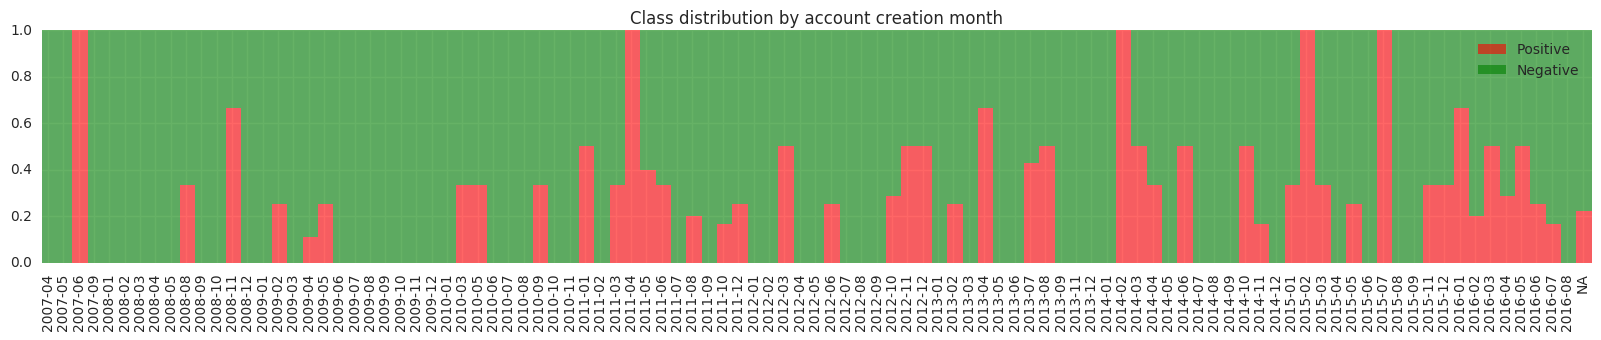

In [41]:
grouped = df_full.groupby(map(lambda dt: dt if pd.notnull(dt) else "NA", df_full["created_at"]))

dts = []
count_pos, count_neg = np.zeros(len(grouped)), np.zeros(len(grouped))
for i, (dt, group) in enumerate(grouped):
    dts.append(dt)
    count_pos[i] = (sum(group["cls"] == 0))
    count_neg[i] = (sum(group["cls"] == 1))
    
fraction_pos = count_pos / (count_pos + count_neg + 1e-10)
fraction_neg = 1 - fraction_pos

sort_ind = np.argsort(dts)
    
pl.figure(figsize=(20, 3))
pl.bar(np.arange(len(dts)), fraction_pos[sort_ind], width=1.0, color='red', alpha=0.6, linewidth=0, label="Positive")
pl.bar(np.arange(len(dts)), fraction_neg[sort_ind], bottom=fraction_pos[sort_ind], width=1.0, color='green', alpha=0.6, linewidth=0, label="Negative")
pl.xticks(np.arange(len(dts)) + 0.4, sorted(dts), rotation=90)
pl.title("Class distribution by account creation month")
pl.xlim(0, len(dts))
pl.legend()
pl.show()

Видно, что доля "положительных" аккаунтов в выборке растет с увеличением времени. Посмотрим, где живут пользователи положительной и отрицательной категории. Для этого отметим на карте каждого положительного пользователя красным, а отрицательного -- зеленым цветом ([подсказка](http://anokhin.github.io/img/hw1_map.png)).

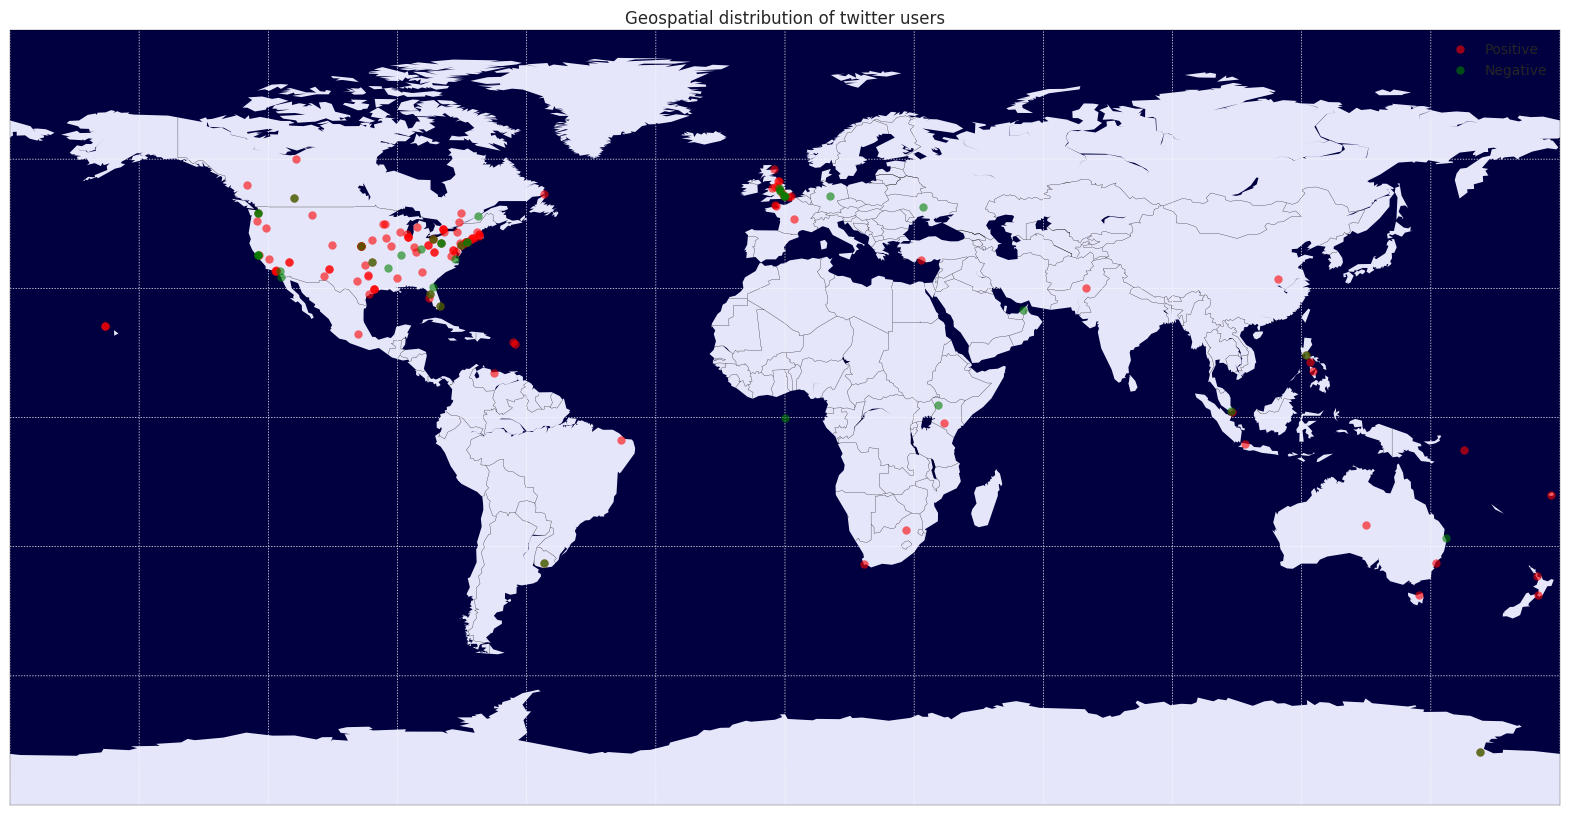

In [42]:
pl.figure(figsize=(20,12))

m = bm.Basemap(projection='cyl', llcrnrlat=-90, urcrnrlat=90, llcrnrlon=-180, urcrnrlon=180, resolution='c')

m.drawcountries(linewidth=0.2)
m.fillcontinents(color='lavender', lake_color='#000040')
m.drawmapboundary(linewidth=0.2, fill_color='#000040')
m.drawparallels(np.arange(-90,90,30),labels=[0,0,0,0], color='white', linewidth=0.5)
m.drawmeridians(np.arange(0,360,30),labels=[0,0,0,0], color='white', linewidth=0.5)

def plot_points_on_map(mx, lons, lats, color, label):
    x, y = mx(lons, lats)
    mx.plot(x, y, 'o', markersize=6, color=color, alpha=0.6, markeredgecolor=color, label=label)
    
df_pos = df_full[(df_full["cls"] == 1) & (pd.notnull(df_full["lat"])) & (pd.notnull(df_full["lon"]))]
plot_points_on_map(m, df_pos["lon"], df_pos["lat"], 'Red', "Positive")

df_neg = df_full[(df_full["cls"] == 0) & (pd.notnull(df_full["lat"])) & (pd.notnull(df_full["lon"]))]
plot_points_on_map(m, df_neg["lon"], df_neg["lat"], 'Green', "Negative")

pl.title("Geospatial distribution of twitter users")
pl.legend()
pl.show()

В последней картинке есть проблема: сервис геоинформации определяет координаты с точностью до города, поэтому точки, соответствующте нескольким пользователям, могут накладываться. Предложите и реализуйте способ, позволяющий справиться с этой проблемой.

#### Опредилим пользователи какого класса популярнее, а именно пользователи какого класса имеют больше фолловеров. 

Для этого
     1. Посчитайте дескриптивные статистики для признака followers_count -- min, max, mean и median 
     2. Постройте гистограммы для пользователей двух классов. 
     3. На основе полученных данных ответьте на вопросы 
         1. Почему mean и median имеют разные значения?
         2. Пользователи какого класса популярнее? Аргументируйте ответ.
Подсказка: так как пользователей позитивного класса в 3.5 раза больше, чем негативного прежде чем приступать к анализу необходимо случайным образом выбрать по N(N>=500) пользователей негативного и позитивного классов. 

In [74]:
sample_number = 500
users_wth_neg_class = df_full[df_full["cls"]==0].sample(sample_number)
users_wth_pos_class = df_full[df_full["cls"]==1].sample(sample_number)


Minimal value positive: 31, negative 18 
Maximal value positive: 24191, negative 16927
Mean value positive: 2517.473684, negative 1878.523810
Median value positive: nan, negative nan 


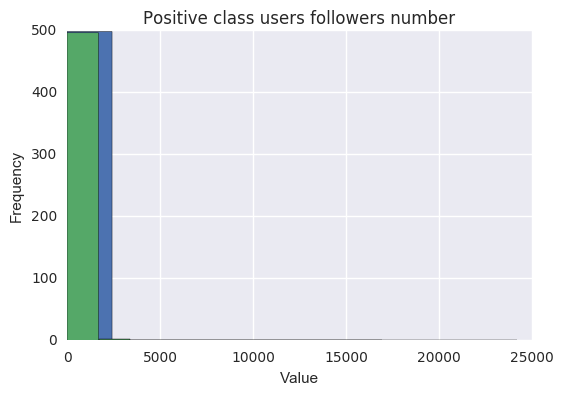

In [79]:
print "Minimal value positive: %d, negative %d " % (np.min(users_wth_pos_class["followers_count"]), np.min(users_wth_neg_class["followers_count"]))
print "Maximal value positive: %d, negative %d" % (np.max(users_wth_pos_class["followers_count"]), np.max(users_wth_neg_class["followers_count"]))
print "Mean value positive: %f, negative %f" % (np.mean(users_wth_pos_class["followers_count"]), np.mean(users_wth_neg_class["followers_count"]))
print "Median value positive: %f, negative %f " % (np.median(users_wth_pos_class["followers_count"]), np.median(users_wth_neg_class["followers_count"]))

plt.hist(users_wth_pos_class_fill_0["followers_count"])
plt.hist(users_wth_neg_class_fill_0["followers_count"])
plt.title(" Followers number ")
plt.xlabel("Value")
plt.ylabel("Frequency")


Смотрим на полученный data frame и сохраняем его в .csv файл.

In [45]:
OUT_FILE_PATH = "hw1_out.csv"
print "Saving output data frame to %s" % OUT_FILE_PATH
df_full.to_csv(OUT_FILE_PATH, sep="\t", index=False, encoding="utf-8", quoting=csv.QUOTE_NONNUMERIC)
df_full.head()

Saving output data frame to hw1_out.csv


,uid,cls,name,screen_name,description,verified,location,lat,lon,country,created_at,followers_count,friends_count,statuses_count,favourites_count,listed_count
0,202388889,1.0,Kim Salter,mustangkim11,Author- Artist-Marvel-Cars-Books-Music,False,"Gulfport, FL",27.74836,-82.70343,United States,2010-10,1052.0,1949.0,9448.0,21209.0,26.0
1,1392518336,0.0,Tomboy Tarts,TomboyTarts,Celebrating the classic tomboy spirit with a b...,False,Singapore/Malaysia,1.5486,103.5269,Malaysia,2013-04,1179.0,832.0,19093.0,7124.0,103.0
2,361208576,1.0,THE MANC GEEK,BigA85GL,"Mancunian geek, blogger/writer/reviewer. Consu...",False,"Manchester, UK",53.48095,-2.23743,United Kingdom,2011-08,634.0,576.0,7799.0,1124.0,27.0
3,1535215357,1.0,L,laurynjiles,I'd rather be in Paris.,False,Marvel. DC.,None,None,None,2013-06,2365.0,2429.0,187891.0,87392.0,68.0
4,4396196375,1.0,Chadwick|💋💋|Chill,ChadwickNChill,#ChadwickAndChill• #fan-#official ❤️Fest for @...,False,God is my refuge; gem❤️,None,None,None,2015-12,1248.0,959.0,34537.0,25288.0,75.0


In [50]:
from collections import Counter

n=0
for i in df_full["followers_count"]:
    if np.isnan(i):
        n+=1

In [51]:
n

11650

In [73]:
df_full[:300]

,uid,cls,name,screen_name,description,verified,location,lat,lon,country,created_at,followers_count,friends_count,statuses_count,favourites_count,listed_count
0,202388889,1.0,Kim Salter,mustangkim11,Author- Artist-Marvel-Cars-Books-Music,False,"Gulfport, FL",27.74836,-82.70343,United States,2010-10,1052.0,1949.0,9448.0,21209.0,26.0
1,1392518336,0.0,Tomboy Tarts,TomboyTarts,Celebrating the classic tomboy spirit with a b...,False,Singapore/Malaysia,1.5486,103.5269,Malaysia,2013-04,1179.0,832.0,19093.0,7124.0,103.0
2,361208576,1.0,THE MANC GEEK,BigA85GL,"Mancunian geek, blogger/writer/reviewer. Consu...",False,"Manchester, UK",53.48095,-2.23743,United Kingdom,2011-08,634.0,576.0,7799.0,1124.0,27.0
3,1535215357,1.0,L,laurynjiles,I'd rather be in Paris.,False,Marvel. DC.,None,None,None,2013-06,2365.0,2429.0,187891.0,87392.0,68.0
4,4396196375,1.0,Chadwick|💋💋|Chill,ChadwickNChill,#ChadwickAndChill• #fan-#official ❤️Fest for @...,False,God is my refuge; gem❤️,None,None,None,2015-12,1248.0,959.0,34537.0,25288.0,75.0
5,17938477,1.0,Skelly @SPX B10,SkellyScribbles,"visual artist, writer, and photographer.",False,"Richmond, VA",37.55376,-77.46026,United States,2008-12,326.0,484.0,5231.0,7703.0,55.0
6,720288026681716737,1.0,Zane Savage,SiNGLEGADGET,"Current gadgets, tech news and reviews, in a s...",False,"Toronto, Ontario",43.70011,-79.4163,Canada,2016-04,64.0,70.0,8892.0,38.0,86.0
7,174004739,1.0,marc,_MightyMarc_,NaN,False,NaN,NaN,NaN,NaN,2010-08,365.0,1876.0,56105.0,132340.0,28.0
8,53783678,1.0,Lady Attis ⚦,ladyattis,Your friendly neighbor androgynous android. Lo...,False,"Minneapolis, MN",44.97997,-93.26384,United States,2009-07,758.0,1050.0,37230.0,67192.0,50.0
9,257662370,1.0,Nick Watches Marvel!,NickWatchesMCU,Excelsior #TrueBelievers❗️#MCU‼️ #LukeCage 9/3...,False,"Seattle, WA",47.60621,-122.33207,United States,2011-02,764.0,1356.0,19090.0,9321.0,29.0


In [53]:
11947-11650

297